Using device: mps
Failed to fetch enough hourly data.
Training data length   = 2500 hours
Validation data length = 2500 hours
Episode 1/50, Reward=0.0399, ε=0.900
Episode 2/50, Reward=-0.1655, ε=0.819
Episode 3/50, Reward=-0.0132, ε=0.746
Episode 4/50, Reward=-0.0622, ε=0.680
Episode 5/50, Reward=-0.0149, ε=0.620
Episode 6/50, Reward=-0.4151, ε=0.566
Episode 7/50, Reward=-0.2061, ε=0.516
Episode 8/50, Reward=0.0909, ε=0.472
Episode 9/50, Reward=0.0179, ε=0.432
Episode 10/50, Reward=-0.1116, ε=0.396
Episode 11/50, Reward=0.4218, ε=0.363
Episode 12/50, Reward=0.8682, ε=0.333
Episode 13/50, Reward=1.0593, ε=0.306
Episode 14/50, Reward=1.0426, ε=0.282
Episode 15/50, Reward=1.1669, ε=0.260
Episode 16/50, Reward=1.0445, ε=0.240
Episode 17/50, Reward=1.1858, ε=0.222
Episode 18/50, Reward=1.1877, ε=0.205
Episode 19/50, Reward=1.2476, ε=0.191
Episode 20/50, Reward=1.3004, ε=0.177
Episode 21/50, Reward=1.0110, ε=0.165
Episode 22/50, Reward=0.9993, ε=0.154
Episode 23/50, Reward=1.1860, ε=0.144
Ep

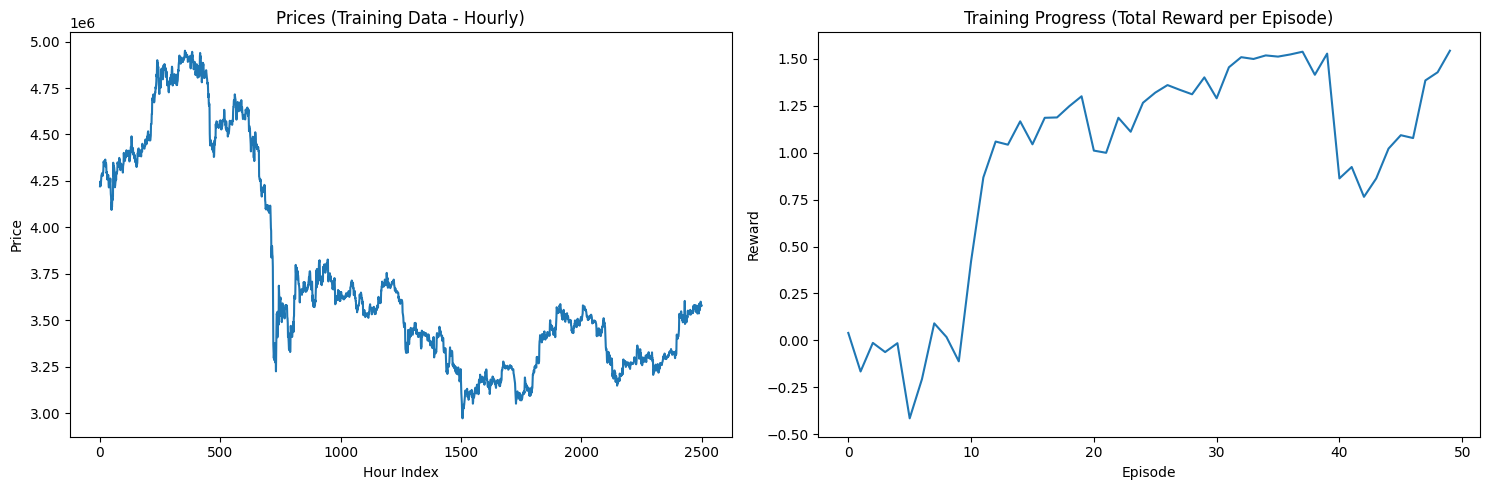


----- Validation Results (Hourly) -----
 Starting Balance: 5,000,000.00 KRW
 Final Balance:    5,377,678.01 KRW
 Total PnL:        377,678.01 KRW (7.55%)


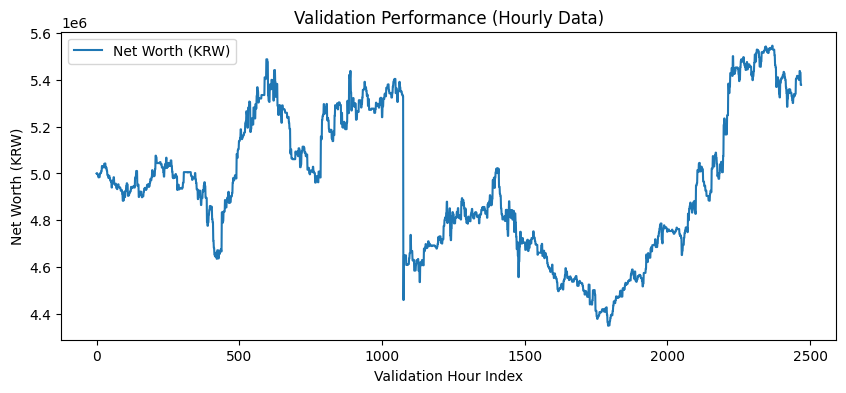

In [2]:
# 2.1 --> 2.1.1 you can now vary the no. of episodes

import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Device selection
device = torch.device(
    "cuda" if torch.cuda.is_available() else 
    "mps" if torch.backends.mps.is_available() else 
    "cpu"
)
print(f"Using device: {device}")

def fetch_historical_data(quote="KRW", target="ETH", hours=8760):
    """
    Fetches 'hours' of historical data (e.g., 8,760 hours ~ 1 year if hours=8760).
    
    Uses the Bithumb 1h candlestick endpoint:
    https://api.bithumb.com/public/candlestick/{target}_{quote}/1h
    
    Returns a NumPy array of closing prices (floats).
    """
    base_url = f"https://api.bithumb.com/public/candlestick/{target}_{quote}/1h"
    
    try:
        response = requests.get(base_url, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        if data.get("status") != "0000":
            print(f"API Error: {data.get('message', 'Unknown error')}")
            return None
            
        candlesticks = data.get("data", [])
        if not candlesticks:
            print("No hourly data found in response.")
            return None
            
        # According to Bithumb documentation for 1h candlestick data, each entry is:
        # [timestamp, open, close, high, low, volume]
        # The closing price is index 2.
        # We'll slice the last 'hours' entries and extract that close value.
        prices = [float(entry[2]) for entry in candlesticks[-hours:]]
        return np.array(prices, dtype=np.float32)
        
    except Exception as e:
        print(f"Error fetching hourly data: {str(e)}")
        return None

class EnhancedTradingEnv:
    """
    Environment for trading on a sequence of hourly prices.
    Each step moves forward by 1 hour in 'prices'.
    """
    def __init__(self, prices, window_size=30, initial_balance=10000.0):
        self.prices = prices
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.reset()
        
    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.position = 0.0
        self.net_worth = [self.initial_balance] * self.window_size
        return self._get_observation()
    
    def _get_observation(self):
        # Last 'window_size' hours of prices
        price_window = self.prices[self.current_step - self.window_size : self.current_step]
        
        # Normalize
        mean_p = np.mean(price_window)
        std_p = np.std(price_window) if np.std(price_window) > 0 else 1.0
        normalized_prices = (price_window - mean_p) / std_p
        
        # Simple volatility indicator
        returns = np.diff(price_window) / price_window[:-1] if len(price_window) > 1 else [0]
        volatility = np.std(returns) if len(returns) > 1 else 0.0
        
        # Combine features (prices + 3 extras)
        return np.concatenate([
            normalized_prices,
            [
                self.balance / self.initial_balance,
                self.position,
                volatility
            ]
        ]).astype(np.float32)
    
    def step(self, action):
        current_price = self.prices[self.current_step]
        reward = 0.0
        
        # Action space: 0=hold, 1=buy, 2=sell
        if action == 1:  # Buy
            max_buy = self.balance / current_price
            self.position += max_buy
            self.balance -= max_buy * current_price
        elif action == 2:  # Sell
            self.balance += self.position * current_price
            self.position = 0.0
            
        # Update net worth
        current_net_worth = self.balance + self.position * current_price
        self.net_worth.append(current_net_worth)
        
        # Reward = log change in net worth
        reward = np.log(current_net_worth / self.net_worth[-2])
        
        self.current_step += 1
        done = (self.current_step >= len(self.prices) - 1)
        
        return self._get_observation(), reward, done

class CNN_DQN(nn.Module):
    """
    CNN-based DQN for trading on hourly data.
    Only the first 'window_size' elements are convolved;
    the last 3 (balance ratio, position, volatility) are appended after.
    """
    def __init__(self, window_size, num_actions):
        super(CNN_DQN, self).__init__()
        self.window_size = window_size

        # 1D CNN feature extractor for prices
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        conv_out_size = self._conv_out(window_size)

        # Fully-connected head:
        # conv_out_size + 3 extra scalar features
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size + 3, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )

    def _conv_out(self, size):
        with torch.no_grad():
            o = self.conv(torch.zeros(1, 1, size))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        # x shape: (batch_size, window_size + 3)
        batch_size = x.size(0)
        
        # First 'window_size' go to CNN
        prices = x[:, : self.window_size]  
        extra  = x[:, self.window_size : ]  
        
        conv_input = prices.unsqueeze(1)       
        conv_output = self.conv(conv_input)
        conv_flat = conv_output.view(batch_size, -1)
        
        # Concatenate the 3 extra features
        combined = torch.cat([conv_flat, extra], dim=1)
        q_values = self.fc(combined)
        return q_values

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

def plot_training_progress(episode_rewards, prices):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(prices)
    plt.title("Prices (Training Data - Hourly)")
    plt.xlabel("Hour Index")
    plt.ylabel("Price")
    
    plt.subplot(1, 2, 2)
    plt.plot(episode_rewards)
    plt.title("Training Progress (Total Reward per Episode)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # 1) Fetch (for example) 8,760 hours (1 year) or 17,520 hours (2 years) of data
    coin = "ETH"
    quote = "KRW"
    
    # Example: 2 years ~ 17,520 hours
    total_hours = 17520
    all_prices = fetch_historical_data(quote=quote, target=coin, hours=total_hours)
    
    if all_prices is None or len(all_prices) < total_hours:
        print("Failed to fetch enough hourly data.")
        exit(1)
        
    # 2) Split data: half for training, half for validation (or choose your ratio)
    split_index = len(all_prices) // 2
    training_prices   = all_prices[:split_index]
    validation_prices = all_prices[split_index:]
    
    print(f"Training data length   = {len(training_prices)} hours")
    print(f"Validation data length = {len(validation_prices)} hours")
    
    # 3) Set up the environment with training data
    env = EnhancedTradingEnv(prices=training_prices, window_size=30, initial_balance=10000)
    state_size = len(env._get_observation())  # should be 30 + 3 = 33
    num_actions = 3
    
    # 4) Initialize model and target network
    model = CNN_DQN(window_size=30, num_actions=num_actions).to(device)
    target_net = CNN_DQN(window_size=30, num_actions=num_actions).to(device)
    target_net.load_state_dict(model.state_dict())
    
    # 5) Training hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    replay_buffer = ReplayBuffer(capacity=10000)
    
    batch_size = 64
    gamma = 0.99
    epsilon_start = 0.9
    epsilon_end   = 0.05
    epsilon_decay = 10
    episodes = 50  # For hourly, you might do more or fewer episodes
    
    episode_rewards = []
    
    # 6) Training loop
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0.0
        
        # Compute decaying epsilon
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1.0 * episode / epsilon_decay)
        
        while True:
            # Epsilon-greedy action
            if random.random() > epsilon:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = model(state_tensor).argmax(dim=1).item()
            else:
                action = random.randint(0, num_actions - 1)
            
            next_state, reward, done = env.step(action)
            total_reward += reward
            
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            
            # Learn if we have enough samples
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                
                states      = torch.FloatTensor(states).to(device)
                actions     = torch.LongTensor(actions).to(device)
                rewards     = torch.FloatTensor(rewards).to(device)
                next_states = torch.FloatTensor(next_states).to(device)
                dones       = torch.BoolTensor(dones).to(device)
                
                # Current Q-values
                current_q = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                
                # Target Q-values from the target network
                with torch.no_grad():
                    next_q = target_net(next_states).max(dim=1)[0]
                    target_q = rewards + gamma * next_q * (~dones)
                
                # MSE loss
                loss = nn.MSELoss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            
            if done:
                break
        
        # Update target net every 10 episodes
        if (episode + 1) % 10 == 0:
            target_net.load_state_dict(model.state_dict())
        
        episode_rewards.append(total_reward)
        print(f"Episode {episode+1}/{episodes}, Reward={total_reward:.4f}, ε={epsilon:.3f}")
    
    # 7) Plot training progress on the training data (hourly)
    plot_training_progress(episode_rewards, training_prices)

def validate_model(model, prices, window_size=30, initial_balance=10000.0):
    """
    Runs a validation episode on 'prices' (hourly) using a purely greedy policy
    from the trained 'model'. Returns hour-by-hour records, including:
    
      - 'hour_index': which hour in the price series
      - 'action': 0=hold, 1=buy, 2=sell
      - 'net_worth': in KRW at the end of that step
      - 'hourly_pnl': net_worth - previous hour's net_worth (KRW)
      
    Prints a summary of final PnL at the end.
    """
    env = EnhancedTradingEnv(prices=prices, window_size=window_size, initial_balance=initial_balance)
    state = env.reset()
    
    done = False
    prev_net_worth = env.net_worth[-1]  # Should be initial_balance on reset
    hourly_records = []
    
    while not done:
        # Greedy action selection
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = model(state_tensor).argmax(dim=1).item()
        
        next_state, _, done = env.step(action)
        current_net_worth = env.net_worth[-1]
        
        hourly_pnl = current_net_worth - prev_net_worth
        hourly_records.append({
            "hour_index": env.current_step,
            "action": action,
            "net_worth": current_net_worth,
            "hourly_pnl": hourly_pnl
        })
        
        prev_net_worth = current_net_worth
        state = next_state
    
    # Final summary
    final_balance = env.net_worth[-1]
    total_pnl = final_balance - initial_balance
    pct_return = (total_pnl / initial_balance) * 100.0
    
    print("\n----- Validation Results (Hourly) -----")
    print(f" Starting Balance: {initial_balance:,.2f} KRW")
    print(f" Final Balance:    {final_balance:,.2f} KRW")
    print(f" Total PnL:        {total_pnl:,.2f} KRW ({pct_return:.2f}%)")
    
    return hourly_records

if __name__ == "__main__":
    # After training finishes...
    
    # 8) Run validation on the 'validation_prices'
    validation_start_balance = 5_000_000.0
    validation_data = validate_model(
        model,
        prices=validation_prices, 
        window_size=30, 
        initial_balance=validation_start_balance
    )
    
    # 9) Inspect or plot the hour-by-hour results
    # for record in validation_data:
    #     print(record)
    
    # Plot net worth over validation
    networth_vals = [r["net_worth"] for r in validation_data]
    plt.figure(figsize=(10, 4))
    plt.plot(networth_vals, label="Net Worth (KRW)")
    plt.title("Validation Performance (Hourly Data)")
    plt.xlabel("Validation Hour Index")
    plt.ylabel("Net Worth (KRW)")
    plt.legend()
    plt.show()
